#### Imports

In [1]:
# Changes:
# Different hyperparams
# deterministic evaluation


# Basic imports & versions
import sys, os, json, time, copy
import numpy as np
import pandas as pd
import gymnasium as gym
import matplotlib.pyplot as plt
import torch as th

# SB3
from stable_baselines3 import A2C
from stable_baselines3.common.monitor import Monitor

# Utils and CityLearn
from utils.env_utils import keep_only_electrical_storage, keep_only_core_observations, PowerScaledDiscreteActions
import citylearn
from citylearn.data import DataSet
from citylearn.citylearn import CityLearnEnv
from citylearn.wrappers import NormalizedObservationWrapper, StableBaselines3Wrapper

print('Python:', sys.version.split()[0])
print('Torch :', th.__version__)
print('CityLearn:', citylearn.__version__)

Couldn't import dot_parser, loading of dot files will not be possible.


2025-09-23 11:29:40.647005: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-23 11:29:40.660992: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758619780.676382  586065 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758619780.680849  586065 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1758619780.692483  586065 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Python: 3.11.7
Torch : 2.7.0+cu126
CityLearn: 2.4.1


#### Variables

In [2]:
# Configuration (kept consistent with other notebooks)
DATASET_NAME = 'citylearn_challenge_2023_phase_3_1'  # adjust if needed
ROOT_DIR = r'/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1'
LOG_DIR = r'/hkfs/home/haicore/iai/cj9272/logs/a2c'
REWARD_FN = {  # CostReward 
    'type': 'citylearn.reward_function.CostReward',
    'attributes': {}
}
PRICING_FILE = 'pricing_germany_2023_june_to_august.csv'
ONLY_ELECTRICAL_STORAGE = True
ACTION_LABELS = ['discharge_full','discharge_half','idle','charge_half','charge_full']
NAME_TO_FRAC = {
    'discharge_full': -1.0,
    'discharge_half': -0.5,
    'idle': 0.0,
    'charge_half': 0.5,
    'charge_full': 1.0,
}
INT_TO_FRAC = np.array([NAME_TO_FRAC[n] for n in ACTION_LABELS], dtype=np.float32)
EVAL_EPISODES = 10

In [19]:
# --- Load schema ---
dataset = DataSet()
schema = dataset.get_schema(DATASET_NAME)
schema['root_directory'] = ROOT_DIR
schema['reward_function'] = REWARD_FN

# Set pricing file on all buildings
price_file = PRICING_FILE
if 'buildings' not in schema:
    raise RuntimeError("schema does not contain 'buildings' (make sure schema is loaded)")
for bname, bconf in schema['buildings'].items():
    bconf['pricing'] = price_file

# Narrow to electrical storage and core observations (same as other notebooks)
schema = keep_only_electrical_storage(schema)
schema = keep_only_core_observations(schema, extra_keep=['carbon_intensity', 'non_shiftable_load'], drop_predictions=False)

# Keep only one building for Discrete(5)
one_building = "Building_1"
schema_1b = dict(schema)
schema_1b['buildings'] = {k: v for k, v in schema['buildings'].items() if k == one_building}
if not schema_1b['buildings']:
    raise RuntimeError(f"{one_building} not found in schema['buildings']")

# Create base env
env = CityLearnEnv(schema_1b, central_agent=True)

# Debug
print('Initial time step:', env.time_step)
print('Number of time steps:', env.time_steps)
print('Central agent:', env.central_agent)
print('Number of buildings:', len(env.buildings))
print('Electrical storage capacity:', {b.name: b.electrical_storage.capacity for b in env.buildings})
print('Action_space:', env.action_space)
print('Number of Observations:', len(env.observations[0]))

INFO:root:Go here /home/iai/cj9272/.cache/citylearn/v2.4.1/datasets/citylearn_challenge_2023_phase_3_1/schema.json 


/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-09-23_12-32-52'
Initial time step: 0
Number of time steps: 2208
Central agent: True
Number of buildings: 1
Electrical storage capacity: {'Building_1': 4.0}
Action_space: [Box(-1.0, 1.0, (1,), float32)]
Number of Observations: 6


In [21]:
import os, csv, time
import numpy as np
import pandas as pd
from stable_baselines3.common.callbacks import BaseCallback
from citylearn.citylearn import CityLearnEnv

class TrainStepCSVLogger(BaseCallback):
    """Pro-Schritt-Logger -> logs/<subdir>/train_steps.csv (VecEnv + Monitor kompatibel)."""
    def __init__(
        self,
        save_dir="logs/a2c",
        filename="a2c_train_steps.csv",
        action_labels=None,
        action_fracs=None,
        flush_every_steps=5000,
        verbose=0
    ):
        super().__init__(verbose)
        self.save_dir = save_dir
        self.filepath = os.path.join(save_dir, filename)
        self.action_labels = action_labels or ['discharge_full','discharge_half','idle','charge_half','charge_full']
        self.action_fracs  = np.array(action_fracs if action_fracs is not None else [-1., -0.5, 0., 0.5, 1.], dtype=float)
        self.flush_every_steps = int(flush_every_steps)

        self._fh = None
        self._writer = None
        self._t0 = None
        self._current_ep_counts = None  # pro Env laufende Episodennummer
        self._rows = []  
        self.df = None
        self.ep_df = None

    # ---------- helpers ----------
    @staticmethod
    def _unwrap_to_citylearn(env):
        cur, seen = env, set()
        while cur is not None and id(cur) not in seen:
            seen.add(id(cur))
            if isinstance(cur, CityLearnEnv):
                return cur
            cur = getattr(cur, "env", getattr(cur, "unwrapped", None))
        return None

    def _get_citylearn_env_for_idx(self, idx: int):
        # DummyVecEnv hat .envs, SubprocVecEnv nutzt env_method/get_attr, aber hier meist DummyVecEnv.
        venv = self.training_env
        base = None
        if hasattr(venv, "envs"):                 # DummyVecEnv
            base = self._unwrap_to_citylearn(venv.envs[idx])
        else:
            try:
                base = self._unwrap_to_citylearn(venv.get_attr("env")[idx])
            except Exception:
                base = None
        return base

    # ---------- SB3 hooks ----------
    def _on_training_start(self) -> None:
        os.makedirs(self.save_dir, exist_ok=True)
        self._t0 = time.time()
        n_envs = int(getattr(self.training_env, "num_envs", 1))
        self._current_ep_counts = [0]*n_envs

        new_file = not os.path.exists(self.filepath) or os.path.getsize(self.filepath) == 0
        self._fh = open(self.filepath, "a", newline="")
        self._writer = csv.writer(self._fh)
        if new_file:
            self._writer.writerow([
                # meta
                "global_step","time_sec","env_id","episode",
                # action + reward
                "action_id","action_label","action_frac","reward",
                # CityLearn internals (t-1; konsistent mit obs)
                "price","net_load","non_shiftable_load","cooling_load","heating_load","dhw_load",
                "chargers_load","storage_load","solar","battery_soc","battery_energy_balance",
                "simulate_power_outage","power_outage"
            ])
            self._fh.flush()

    def _on_step(self) -> bool:
        obs_vec = self.locals.get("new_obs")
        acts    = self.locals.get("actions")
        rews    = self.locals.get("rewards")
        dones   = self.locals.get("dones")
        infos   = self.locals.get("infos", [])
        step    = int(self.num_timesteps)

        n_envs = len(rews) if hasattr(rews, "__len__") else 1
        for idx in range(n_envs):
            # Werte pro Env robust holen
            act  = acts[idx] if hasattr(acts, "__len__") else acts
            rew  = rews[idx] if hasattr(rews, "__len__") else rews
            done = bool(dones[idx]) if hasattr(dones, "__len__") else bool(dones)

            # Diskrete Action-ID extrahieren
            try:
                a_id = int(act) if np.isscalar(act) else int(np.array(act).reshape(-1)[0])
            except Exception:
                a_id = None

            # Label & Frac
            a_label = (self.action_labels[a_id] if (a_id is not None and 0 <= a_id < len(self.action_labels)) else None)
            a_frac  = (float(self.action_fracs[a_id]) if (a_id is not None and 0 <= a_id < len(self.action_fracs)) else None)

            row = {
                "global_step": step,
                "time_sec": f"{time.time()-self._t0:.3f}",
                "env_id": idx,
                "episode": self._current_ep_counts[idx],
                "action_id": (a_id if a_id is not None else ""),
                "action_label": a_label if a_label is not None else "",
                "action_frac": f"{a_frac:.1f}" if a_frac is not None else "",
                "reward": f"{float(rew):.6f}",
                # CityLearn Felder folgen, evtl. leer
                "price": "", "net_load": "", "non_shiftable_load": "",
                "cooling_load": "", "heating_load": "", "dhw_load": "",
                "chargers_load": "", "storage_load": "", "solar": "",
                "battery_soc": "", "battery_energy_balance": "",
                "simulate_power_outage": "", "power_outage": ""
            }

            # CityLearn-Interna (t-1 = konsistent zu obs)
            try:
                base = self._get_citylearn_env_for_idx(idx)
                if base is not None and len(base.buildings) > 0:
                    b = base.buildings[0]
                    t  = int(getattr(b, "time_step", 0))
                    tp = max(0, t-1)

                    chargers_arr = getattr(b, "_Building__chargers_electricity_consumption", None)
                    chargers_tp  = float(chargers_arr[tp]) if chargers_arr is not None else np.nan

                    row.update({
                        "price": float(b.pricing.electricity_pricing[tp]),
                        "net_load": float(b.net_electricity_consumption[tp]),
                        "non_shiftable_load": float(b.non_shiftable_load_device.electricity_consumption[tp]),
                        "cooling_load": float(b.cooling_device.electricity_consumption[tp]),
                        "heating_load": float(b.heating_device.electricity_consumption[tp]),
                        "dhw_load": float(b.dhw_device.electricity_consumption[tp]),
                        "chargers_load": chargers_tp,
                        "storage_load": float(b.electrical_storage.electricity_consumption[tp]),
                        "solar": float(b.solar_generation[tp]),
                        "battery_soc": float(b.electrical_storage.soc[tp]),
                        "battery_energy_balance": float(b.electrical_storage.energy_balance[tp]),
                        "simulate_power_outage": bool(getattr(b, 'simulate_power_outage', False)),
                        "power_outage": bool(getattr(b, 'power_outage', False)),
                    })
            except Exception:
                pass

            row_df = {
                "global_step": step,
                "env_id": idx,
                "episode": self._current_ep_counts[idx],
                "action_id": a_id if a_id is not None else None,
                "action_label": a_label if a_label is not None else None,
                "action_frac": float(a_frac) if a_frac is not None else None,
                "reward": float(rew),
                "price": row["price"] if row["price"] != "" else None,
                "net_load": row["net_load"] if row["net_load"] != "" else None,
                "non_shiftable_load": row["non_shiftable_load"] if row["non_shiftable_load"] != "" else None,
                "cooling_load": row["cooling_load"] if row["cooling_load"] != "" else None,
                "heating_load": row["heating_load"] if row["heating_load"] != "" else None,
                "dhw_load": row["dhw_load"] if row["dhw_load"] != "" else None,
                "chargers_load": row["chargers_load"] if row["chargers_load"] != "" else None,
                "storage_load": row["storage_load"] if row["storage_load"] != "" else None,
                "solar": row["solar"] if row["solar"] != "" else None,
                "battery_soc": row["battery_soc"] if row["battery_soc"] != "" else None,
                "battery_energy_balance": row["battery_energy_balance"] if row["battery_energy_balance"] != "" else None,
            }
            self._rows.append(row_df)


            # schreiben
            self._writer.writerow([
                row["global_step"], row["time_sec"], row["env_id"], row["episode"],
                row["action_id"], row["action_label"], row["action_frac"], row["reward"],
                row["price"], row["net_load"], row["non_shiftable_load"], row["cooling_load"], row["heating_load"],
                row["dhw_load"], row["chargers_load"], row["storage_load"], row["solar"],
                row["battery_soc"], row["battery_energy_balance"],
                row["simulate_power_outage"], row["power_outage"]
            ])

            # Episodenzähler hochzählen
            if done:
                self._current_ep_counts[idx] += 1

        if self.flush_every_steps and (self.num_timesteps % self.flush_every_steps == 0):
            self._fh.flush()
        return True

    def _on_training_end(self) -> None:
        if self._fh is not None:
            self._fh.flush()
            self._fh.close()
            self._fh = None
            self._writer = None
        if self._rows:
            self.df = pd.DataFrame(self._rows)
            # Ep-Übersicht wie im Notebook
            self.ep_df = (self.df.groupby(["env_id","episode"], as_index=False)
                            .agg(ep_return=("reward","sum"),
                                ep_length=("reward","size")))

In [22]:
# Build & Train A2C
def compute_action_scales(cl_env, alpha=0.8):
    """scale = alpha * (P_nom * dt / capacity). alpha<1 gibt Headroom -> weniger Clipping."""
    dt_h = cl_env.schema['seconds_per_time_step'] / 3600.0
    scales = []
    for b in cl_env.buildings:
        cap  = max(b.electrical_storage.capacity, 1e-9)   # kWh
        pnom = b.electrical_storage.nominal_power         # kW
        scales.append(alpha * (pnom * dt_h) / cap)
    return np.array(scales, dtype=np.float32)

os.makedirs(LOG_DIR, exist_ok=True)
scales = compute_action_scales(env) 
print("Action scales (pro Building):", scales)

train_env = NormalizedObservationWrapper(env)
train_env = StableBaselines3Wrapper(train_env)
train_env = PowerScaledDiscreteActions(train_env, scales=scales)
train_env = Monitor(train_env, filename=os.path.join(LOG_DIR, "monitor.csv"))
print('Train action_space:', train_env.action_space)       

TOTAL_TIMESTEPS = 2207 * 50
TRAINING_FILE = "a2c_50episodes_best_params" # num
TRAIN_STEPS_FILE = os.path.join(LOG_DIR, "a2c_train_steps_50episodes_best_params.csv") # num
TRAIN_EPISODES_FILE = os.path.join(LOG_DIR, "a2c_train_episodes_50episodes_best_params.csv") # num


#train_callback = A2CTrainLoggerCallback()  
train_callback = TrainStepCSVLogger(save_dir=LOG_DIR, filename="a2c_train_steps_50episodes_best_params.csv", action_labels=ACTION_LABELS, action_fracs=INT_TO_FRAC)  

model = A2C(
    policy='MlpPolicy',
    env=train_env,
    seed=0,
    learning_rate=0.0002288113668475521,
    gamma=0.9714474177006047,
    #ent_coef=0.06027633760716439,
    ent_coef=0.0,
    n_steps=96,
    vf_coef=0.8917730007820798,
    gae_lambda=0.9927325521002058,
    verbose=1,
    policy_kwargs=dict(net_arch=[256, 256], activation_fn=th.nn.ReLU),
    #normalize_advantage=True, # TODO: try this
    device="cpu",
)

Action scales (pro Building): [0.664]
Train action_space: Discrete(5)
Using cpu device
Wrapping the env in a DummyVecEnv.


In [10]:
start_time = time.time()
model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=train_callback)
print(f"Total time elapsed for {TOTAL_TIMESTEPS} steps: {(time.time()-start_time):.2f} seconds")
model.save(TRAINING_FILE)
print(f"A2C model saved to {os.path.abspath(TRAINING_FILE)}")

print("---------------Train callback: \n", train_callback.df)
print("---------------Episode rewards: \n", train_callback.ep_df)
# Save training logs

train_callback.df.to_csv(TRAIN_STEPS_FILE, index=False)
train_callback.ep_df.to_csv(TRAIN_EPISODES_FILE, index=False)

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.21e+03 |
|    ep_rew_mean        | -270     |
| time/                 |          |
|    fps                | 20       |
|    iterations         | 100      |
|    time_elapsed       | 474      |
|    total_timesteps    | 9600     |
| train/                |          |
|    entropy_loss       | -1.61    |
|    explained_variance | -0.256   |
|    learning_rate      | 0.000229 |
|    n_updates          | 99       |
|    policy_loss        | -1.22    |
|    value_loss         | 0.855    |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.21e+03 |
|    ep_rew_mean        | -270     |
| time/                 |          |
|    fps                | 19       |
|    iterations         | 200      |
|    time_elapsed       | 971      |
|    total_timesteps    | 19200    |
| train/                |          |
|

In [ ]:
# Check train_callback on training episodes
if hasattr(train_callback, 'ep_df') and len(train_callback.ep_df):
    ep_df = train_callback.ep_df
    first_n, last_n = 10, 10
    first_mean = ep_df['ep_return'].head(first_n).mean()
    last_mean  = ep_df['ep_return'].tail(last_n).mean()
    print(f'First {first_n} ep mean return: {first_mean:.3f}')
    print(f'Last  {last_n} ep mean return: {last_mean:.3f}')
    print('Learning indicator (last - first):', f'{(last_mean-first_mean):.3f}')
else:
    print('No episode returns in train_callback.ep_df')

#### Evaluation

In [23]:
schema_eval = copy.deepcopy(schema_1b)
eval_env = CityLearnEnv(schema_eval, central_agent=True)
eval_scales = compute_action_scales(eval_env) 

eval_env = NormalizedObservationWrapper(eval_env)
eval_env = StableBaselines3Wrapper(eval_env)
eval_env = PowerScaledDiscreteActions(eval_env, scales=eval_scales)

model = A2C.load(TRAINING_FILE)
print(f"A2C model loaded from {os.path.abspath(TRAINING_FILE)}")
EVAL_FILE = os.path.join(LOG_DIR, "a2c_eval_20episodes.pkl")

/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-09-23_12-33-52'
A2C model loaded from /hkfs/home/haicore/iai/cj9272/a2c_50episodes_best_params


/hkfs/home/haicore/iai/cj9272/citylearn_env/lib64/python3.11/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [7]:
# ca 2 * eval_episodes min
import pickle 
from citylearn.citylearn import CityLearnEnv

# Enhanced eval: collect actions/rewards and per-step obs series, optionally save to .pkl
def evaluate_with_metrics(model, env, episodes=5, deterministic=True, render=False, save_path=None):

    def action_to_frac(env, action):
        if isinstance(env.action_space, gym.spaces.Discrete):
            return np.array([INT_TO_FRAC[int(action)]], dtype=np.float32)
        elif isinstance(env.action_space, gym.spaces.MultiDiscrete):
            a = np.asarray(action, dtype=int)
            return INT_TO_FRAC[a]
        else:
            return np.asarray(action, dtype=np.float32)

    def _get_base_env(e):
        cur, seen = e, set()
        while cur is not None and id(cur) not in seen:
            seen.add(id(cur))
            if isinstance(cur, CityLearnEnv):
                return cur
            cur = getattr(cur, "env", getattr(cur, "unwrapped", None))
        raise RuntimeError("CityLearnEnv not found inside wrappers.")

    base = _get_base_env(env)
    bld_names = [b.name for b in base.buildings]
    building_name = "Building_1" if "Building_1" in bld_names else bld_names[0]
    b_idx = bld_names.index(building_name)

    obs_names = getattr(base, "observation_names", None)
    if obs_names is None:
        raise AttributeError("CityLearnEnv has no 'observation_names'.")
    obs_b = obs_names[b_idx]
    name_to_idx = {n: i for i, n in enumerate(obs_b)}
    i_net = name_to_idx.get("net_electricity_consumption")
    if i_net is None:
        i_net = name_to_idx.get("net_electricity_consumption_without_storage")
    i_nsl   = name_to_idx.get("non_shiftable_load")
    i_price = name_to_idx.get("electricity_pricing")
    i_solar = name_to_idx.get("solar_generation")

    ep_metrics, all_step_rewards, all_kpis, all_actions = [], [], [], []
    ep_lengths = []
    actions_disc_list, ep_action_fracs = [], []
    ep_rewards_list = []
    ep_net_load, ep_non_shiftable_load, ep_price, ep_solar_generation = [], [], [], []

    t_global_start = time.time()

    for ep in range(1, episodes + 1):
        obs, _ = env.reset()
        done = False
        ep_ret, ep_len = 0.0, 0
        step_rewards = []
        action_list = []

        ep_actions_disc = []
        ep_fracs = []
        ep_net, ep_nsl, ep_prc, ep_sol = [], [], [], []

        t_ep_start = time.time()
        while not done:
            action, _ = model.predict(obs, deterministic=deterministic)
            frac = action_to_frac(env, action)
            action_list.append(frac)

            obs, r, terminated, truncated, info = env.step(action)
            done = bool(terminated or truncated)

            # Discrete(5) single-building -> int id
            if isinstance(env.action_space, gym.spaces.Discrete):
                a_id = int(action)
            else:
                # Fallback: nearest bin for first dimension
                a_id = int(np.argmin(np.abs(INT_TO_FRAC - float(frac[0]))))

            ep_actions_disc.append(a_id)
            ep_fracs.append(float(INT_TO_FRAC[a_id]))
            ep_rewards = float(r)
            step_rewards.append(ep_rewards)
            ep_ret += ep_rewards
            ep_len += 1

            raw = base.observations[b_idx]
            ep_net.append(float(raw[i_net]) if i_net is not None else np.nan)
            ep_nsl.append(float(raw[i_nsl]) if i_nsl is not None else np.nan)
            ep_prc.append(float(raw[i_price]) if i_price is not None else np.nan)
            ep_sol.append(float(raw[i_solar]) if i_solar is not None else np.nan)

            if render:
                env.render()

        kpis = env.unwrapped.evaluate()
        all_kpis.append(kpis)
        all_actions.append(np.vstack(action_list))

        t_ep = time.time() - t_ep_start
        steps_per_sec = ep_len / max(t_ep, 1e-9)
        ep_metrics.append({
            'episode': ep, 'cumulative reward': ep_ret, 'length': ep_len,
            'mean_reward': ep_ret/ep_len if ep_len else np.nan,
            'min_step_reward': float(np.min(step_rewards)),
            'max_step_reward': float(np.max(step_rewards)),
            'std_step_reward': float(np.std(step_rewards)),
            'steps_per_sec': steps_per_sec, 'time_sec': t_ep
        })
        all_step_rewards.extend(step_rewards)

        # Store per-episode sequences
        ep_lengths.append(ep_len)
        actions_disc_list.append(np.asarray(ep_actions_disc, dtype=int))
        ep_action_fracs.append(np.asarray(ep_fracs, dtype=float))
        ep_rewards_list.append(np.asarray(step_rewards, dtype=float))
        ep_net_load.append(np.asarray(ep_net, dtype=float))
        ep_non_shiftable_load.append(np.asarray(ep_nsl, dtype=float))
        ep_price.append(np.asarray(ep_prc, dtype=float))
        ep_solar_generation.append(np.asarray(ep_sol, dtype=float))

        print(f"[Eval] Ep {ep}/{episodes} return={ep_ret:.3f} len={ep_len} "
              f"mean={ep_ret/ep_len:.3f} time={t_ep:.2f}s speed={steps_per_sec:.1f} steps/s")

    print(f"Total eval time: {time.time()-t_global_start:.2f}s  | Avg/ep: {(time.time()-t_global_start)/episodes:.2f}s")
    metrics_df = pd.DataFrame(ep_metrics)
    display(metrics_df)

    # Meta (align with DQN eval dict)
    price_file = schema['buildings'][building_name]['pricing']
    price_path = os.path.join(ROOT_DIR, price_file)
    prc_df = pd.read_csv(price_path)
    T = len(prc_df)

    results = {
        'ep_lengths': np.asarray(ep_lengths, dtype=int),
        'actions_disc_list': actions_disc_list,
        'step_rewards': np.asarray(all_step_rewards, dtype=float),

        'ep_action_fracs': ep_action_fracs,
        'ep_rewards_list': ep_rewards_list,
        'ep_net_load': ep_net_load,
        'ep_non_shiftable_load': ep_non_shiftable_load,
        'ep_price': ep_price,
        'ep_solar_generation': ep_solar_generation,

        'price_df': prc_df,
        'episode_len': T,
        'building_name': building_name,

        # A2C-specific extras
        'metrics_df': metrics_df,
        'episode_kpis': all_kpis,
    }

    if save_path is not None:
        tmp = save_path + ".tmp"
        with open(tmp, "wb") as f:
            pickle.dump(results, f)
        os.replace(tmp, save_path)  # atomic replace
        print(f"A2C eval results saved to {os.path.abspath(save_path)}")

    return metrics_df, np.array(all_step_rewards), all_kpis, all_actions

# Run eval and save
metrics_stoch, step_rewards_stoch, kpis_stoch, actions_stoch = evaluate_with_metrics(
    model, eval_env, episodes=EVAL_EPISODES, deterministic=True, save_path=EVAL_FILE
)

[Eval] Ep 1/10 return=-262.696 len=2207 mean=-0.119 time=114.59s speed=19.3 steps/s
[Eval] Ep 2/10 return=-262.696 len=2207 mean=-0.119 time=115.06s speed=19.2 steps/s
[Eval] Ep 3/10 return=-262.696 len=2207 mean=-0.119 time=115.16s speed=19.2 steps/s
[Eval] Ep 4/10 return=-262.696 len=2207 mean=-0.119 time=115.45s speed=19.1 steps/s
[Eval] Ep 5/10 return=-262.696 len=2207 mean=-0.119 time=115.38s speed=19.1 steps/s
[Eval] Ep 6/10 return=-262.696 len=2207 mean=-0.119 time=115.27s speed=19.1 steps/s
[Eval] Ep 7/10 return=-262.696 len=2207 mean=-0.119 time=115.08s speed=19.2 steps/s
[Eval] Ep 8/10 return=-262.696 len=2207 mean=-0.119 time=115.17s speed=19.2 steps/s
[Eval] Ep 9/10 return=-262.696 len=2207 mean=-0.119 time=115.03s speed=19.2 steps/s
[Eval] Ep 10/10 return=-262.696 len=2207 mean=-0.119 time=115.14s speed=19.2 steps/s
Total eval time: 1151.39s  | Avg/ep: 115.14s


,episode,cumulative reward,length,mean_reward,min_step_reward,max_step_reward,std_step_reward,steps_per_sec,time_sec
0,1,-262.695843,2207,-0.119028,-1.757477,0.073877,0.143639,19.259246,114.594310
1,2,-262.695843,2207,-0.119028,-1.757477,0.073877,0.143639,19.181645,115.057911
2,3,-262.695843,2207,-0.119028,-1.757477,0.073877,0.143639,19.164204,115.162624
3,4,-262.695843,2207,-0.119028,-1.757477,0.073877,0.143639,19.117206,115.445739
4,5,-262.695843,2207,-0.119028,-1.757477,0.073877,0.143639,19.128193,115.379431
5,6,-262.695843,2207,-0.119028,-1.757477,0.073877,0.143639,19.146645,115.268237
6,7,-262.695843,2207,-0.119028,-1.757477,0.073877,0.143639,19.178447,115.077094
7,8,-262.695843,2207,-0.119028,-1.757477,0.073877,0.143639,19.163279,115.168181
8,9,-262.695843,2207,-0.119028,-1.757477,0.073877,0.143639,19.186346,115.029721
9,10,-262.695843,2207,-0.119028,-1.757477,0.073877,0.143639,19.168274,115.138170


A2C eval results saved to /hkfs/home/haicore/iai/cj9272/logs/a2c/a2c_eval_10episodes_1seed.pkl


In [8]:
# ca 5min
import numpy as np, gymnasium as gym

def action_hist(model, env):
    obs, _ = env.reset()
    counts = np.zeros(5, dtype=int)
    done = False
    while not done:
        a, _ = model.predict(obs, deterministic=False)
        if isinstance(env.action_space, gym.spaces.Discrete):
            counts[int(a)] += 1
        else:
            # falls MultiDiscrete o.ä.
            counts[int(a[0])] += 1
        obs, r, term, trunc, _ = env.step(a)
        done = bool(term or trunc)
    print("action counts:", counts, "proportions:", counts / counts.sum())

action_hist(model, eval_env)

action counts: [443 469 533 473 289] proportions: [0.20072497 0.21250566 0.2415043  0.21431808 0.13094699]


In [ ]:
def preview_rewards(model, env, steps=48, deterministic=True):
    obs, _ = env.reset()
    cum = 0.0
    for t in range(steps):
        action, _ = model.predict(obs, deterministic=deterministic)
        obs, r, done, trunc, info = env.step(action)
        r = float(r[0]) if isinstance(r, (list, tuple, np.ndarray)) else float(r)
        cum += r
        print(f"[eval] t={t:04d} r={r:.4f}  cum={cum:.4f}")
        if done or trunc:
            print(f"[eval] episode end at t={t}, return={cum:.4f}")
            break

preview_rewards(model, eval_env, steps=96, deterministic=True)

#### Optuna

In [ ]:
import os, copy, json
import numpy as np
import optuna
from stable_baselines3 import A2C
from stable_baselines3.common.monitor import Monitor
from optuna.pruners import SuccessiveHalvingPruner
from optuna.samplers import TPESampler

WORKER_ID = int(os.getenv("OPTUNA_WORKER_ID", "0"))
ART_DIR = os.path.join(os.getcwd(), "artifacts")
os.makedirs(ART_DIR, exist_ok=True)
STORAGE_URL = f"sqlite:///{os.path.join(ART_DIR, 'optuna_a2c.db')}?timeout=120"
STUDY_NAME = "a2c_citylearn"

def make_env_one_building(schema_src, building_name="Building_1", n_bins=5, monitor=False):
    schema_1b = copy.deepcopy(schema_src)
    schema_1b['buildings'] = {k: v for k, v in schema_src['buildings'].items() if k == building_name}
    if not schema_1b['buildings']:
        raise RuntimeError(f"{building_name} not found in schema['buildings']")
    env = CityLearnEnv(schema_1b, central_agent=True)
    env_scales = compute_action_scales(env) 
    env = NormalizedObservationWrapper(env)
    env = StableBaselines3Wrapper(env)
    env = PowerScaledDiscreteActions(env, scales=env_scales)
    #env = DiscretizeActionWrapper(env, n_bins=n_bins)
    if monitor:
        env = Monitor(env)
    return env

def evaluate_mean_reward(model, env, episodes=2, deterministic=True):
    rewards = []
    for _ in range(episodes):
        obs, _ = env.reset()
        done = False
        ep_ret = 0.0
        while not done:
            act, _ = model.predict(obs, deterministic=deterministic)
            obs, r, terminated, truncated, _ = env.step(act)
            ep_ret += float(r)
            done = bool(terminated or truncated)
        rewards.append(ep_ret)
    return float(np.mean(rewards))

class OptunaEvalPruningCallback:
    def __init__(self, trial, model, eval_env, eval_every_steps, eval_episodes=2):
        self.trial = trial
        self.model = model
        self.eval_env = eval_env
        self.eval_every_steps = int(eval_every_steps)
        self.eval_episodes = int(eval_episodes)
        self._last_step = 0
        self.is_pruned = False

    def __call__(self, locals_, globals_):
        # Called by SB3 when using callback= in learn
        step = int(locals_.get("self").num_timesteps)
        if step - self._last_step >= self.eval_every_steps:
            self._last_step = step
            mean_r = evaluate_mean_reward(self.model, self.eval_env, episodes=self.eval_episodes, deterministic=True)
            self.trial.report(mean_r, step=step)
            if self.trial.should_prune():
                self.is_pruned = True
                return False  # stop training
        return True

def objective(trial: optuna.Trial) -> float:
    # Search space
    lr        = trial.suggest_float("learning_rate", 1e-5, 3e-3, log=True)
    gamma     = trial.suggest_float("gamma", 0.90, 0.9999)
    ent_coef  = trial.suggest_float("ent_coef", 0.0, 0.1)
    n_steps   = trial.suggest_categorical("n_steps", [5, 16, 32, 64])
    vf_coef   = trial.suggest_float("vf_coef", 0.0, 1.0)
    gae_lambda= trial.suggest_float("gae_lambda", 0.8, 1.0)
    net_key   = trial.suggest_categorical("net_arch", ["128x128", "256x256", "256x256x256"])
    net_arch  = [int(x) for x in net_key.split("x")]

    # envs
    train_env = make_env_one_building(schema, building_name="Building_1", n_bins=5, monitor=True)
    eval_env  = make_env_one_building(schema, building_name="Building_1", n_bins=5, monitor=False)
    T = train_env.unwrapped.time_steps

    # short trials
    episodes_per_trial = 3
    total_steps = episodes_per_trial * T

    model = A2C(
        policy="MlpPolicy",
        env=train_env,
        seed=0,
        learning_rate=lr,
        gamma=gamma,
        n_steps=n_steps,
        ent_coef=ent_coef,
        vf_coef=vf_coef,
        gae_lambda=gae_lambda,
        verbose=0,
        policy_kwargs=dict(net_arch=net_arch, activation_fn=th.nn.ReLU),
        device="auto",
    )

    cb = OptunaEvalPruningCallback(trial, model, eval_env, eval_every_steps=max(1, T//2), eval_episodes=2)
    try:
        model.learn(total_timesteps=total_steps, callback=cb)
        if cb.is_pruned:
            raise optuna.TrialPruned()
    finally:
        try: train_env.close()
        except: pass
        try: eval_env.close()
        except: pass

    # final evaluation
    eval_env = make_env_one_building(schema, building_name="Building_1", n_bins=5, monitor=False)
    score = evaluate_mean_reward(model, eval_env, episodes=3, deterministic=True)
    eval_env.close()

    trial.set_user_attr("final_mean_reward", score)
    return score

print(f"PID: {os.getpid()}")

study = optuna.create_study(
    study_name=STUDY_NAME,
    direction="maximize",
    storage=STORAGE_URL,
    load_if_exists=True,
    sampler=TPESampler(seed=None, multivariate=False),  # no fixed seed here
    pruner=SuccessiveHalvingPruner(min_resource=1, reduction_factor=3, min_early_stopping_rate=0),
)
print("Study ready:", STUDY_NAME, STORAGE_URL, "worker:", WORKER_ID)

[I 2025-09-16 11:35:10,247] Using an existing study with name 'a2c_citylearn' instead of creating a new one.


PID: 3915198
Study ready: a2c_citylearn sqlite:////hkfs/home/haicore/iai/cj9272/artifacts/optuna_a2c.db?timeout=120 worker: 0


In [ ]:
# Optuna hyperparameter optimization
#N_TRIALS = 30  # increase as needed
N_TRIALS = None  # let timeout drive the run
TIMEOUT_SECONDS = int((3*3600 + 40*60) / 2)  # 6600 seconds per worker
study.optimize(objective, n_trials=N_TRIALS, timeout=TIMEOUT_SECONDS, gc_after_trial=True, catch=(Exception,))
print("Done. Trials now:", len(study.trials))

In [ ]:
# Print best Trial + Top 10 Trials and store best trial params in artifacts/best_params_*.json
import os, json
import optuna
from collections import defaultdict

ART_DIR = os.path.join(os.getcwd(), "artifacts")
STORAGE_URL = f"sqlite:///{os.path.join(ART_DIR, 'optuna_a2c.db')}?timeout=120"
STUDY_NAME = "a2c_citylearn"

try:
    study = optuna.load_study(study_name=STUDY_NAME, storage=STORAGE_URL)
except Exception as e:
    print("Study konnte nicht geladen werden:", e)
    raise

best = study.best_trial
print("Best trial number:", best.number)
print("Best value (objective):", best.value)
print("Best params:")
for k, v in best.params.items():
    print(f"  {k}: {v}")

# Top-K completed trials (by objective value)
top_k = 10
completed = [t for t in study.trials if t.value is not None]
completed_sorted = sorted(completed, key=lambda t: t.value, reverse=True)[:top_k]
print(f"\nTop {min(top_k, len(completed_sorted))} trials (number, value):")
for t in completed_sorted:
    print(f"  #{t.number}\t{t.value}\t{t.params}")

# Per-parameter summary (unique values seen)
param_vals = defaultdict(set)
for t in study.trials:
    for k, v in t.params.items():
        param_vals[k].add(v)

print("\nParameter summary (unique values seen):")
for k in sorted(param_vals.keys()):
    vals = list(param_vals[k])
    print(f"  {k}: {len(vals)} unique (examples: {vals[:6]})")

# Save best params to artifacts
os.makedirs(ART_DIR, exist_ok=True)
out_path = os.path.join(ART_DIR, f"best_params_{STUDY_NAME}.json")
with open(out_path, "w") as f:
    json.dump({"trial": int(best.number), "value": float(best.value), "params": best.params}, f, indent=2)
print("\nSaved best params to:", out_path)

Best trial number: 1
Best value (objective): -265.46900342672353
Best params:
  learning_rate: 0.0002288113668475521
  gamma: 0.9714474177006047
  ent_coef: 0.06027633760716439
  n_steps: 32
  vf_coef: 0.8917730007820798
  gae_lambda: 0.9927325521002058
  net_arch: 256x256

Top 10 trials (number, value):
  #1	-265.46900342672353	{'learning_rate': 0.0002288113668475521, 'gamma': 0.9714474177006047, 'ent_coef': 0.06027633760716439, 'n_steps': 32, 'vf_coef': 0.8917730007820798, 'gae_lambda': 0.9927325521002058, 'net_arch': '256x256'}
  #2	-265.46900342672353	{'learning_rate': 0.00025533788451512354, 'gamma': 0.9924671041654368, 'ent_coef': 0.007103605819788694, 'n_steps': 32, 'vf_coef': 0.8700121482468192, 'gae_lambda': 0.9957236684465528, 'net_arch': '128x128'}
  #3	-265.46900342672353	{'learning_rate': 1.9632702887198374e-05, 'gamma': 0.9639281100306196, 'ent_coef': 0.014335328740904641, 'n_steps': 5, 'vf_coef': 0.7742336894342167, 'gae_lambda': 0.8912300664433097, 'net_arch': '256x256x

#### Plots

Eval results loaded from /hkfs/home/haicore/iai/cj9272/logs/a2c/a2c_eval_20episodes.pkl.


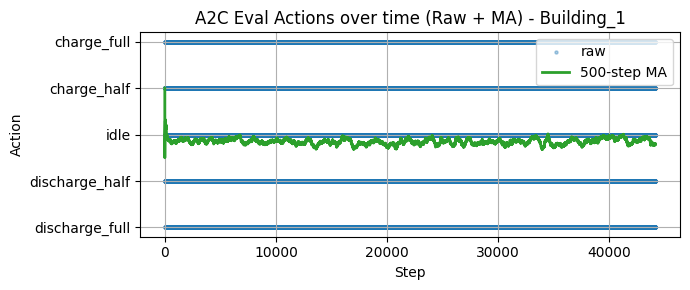

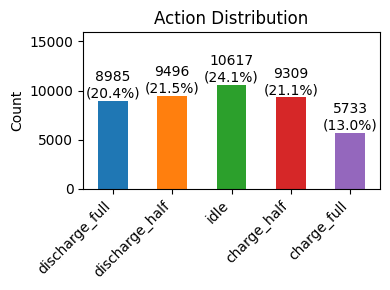

Eval results loaded from /hkfs/home/haicore/iai/cj9272/logs/a2c/a2c_eval_20episodes.pkl.


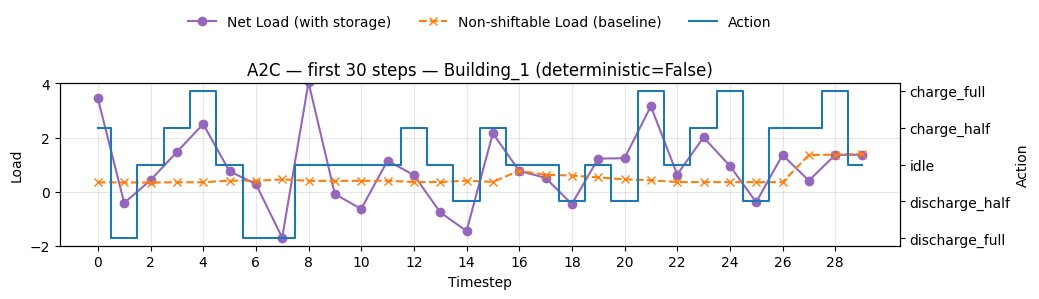

Eval results loaded from /hkfs/home/haicore/iai/cj9272/logs/a2c/a2c_eval_20episodes.pkl.


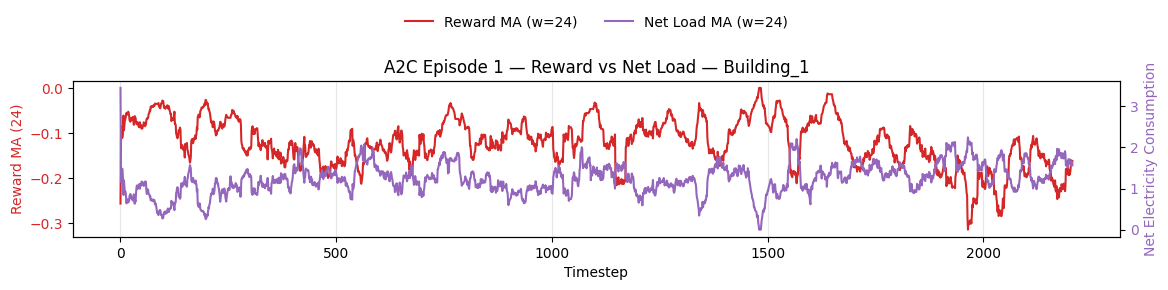

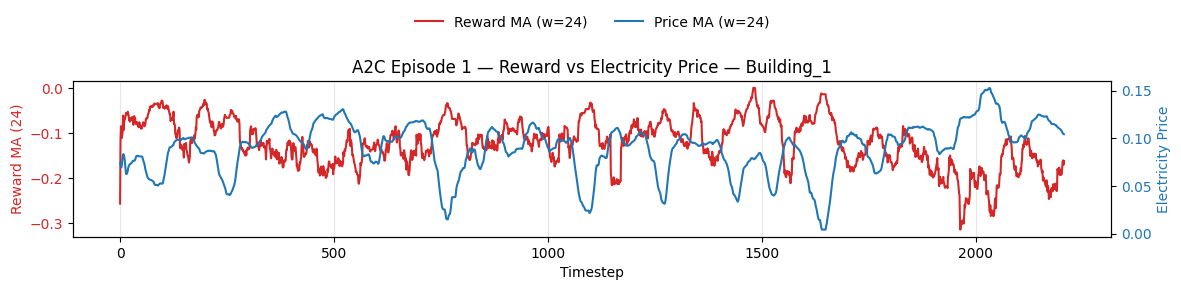

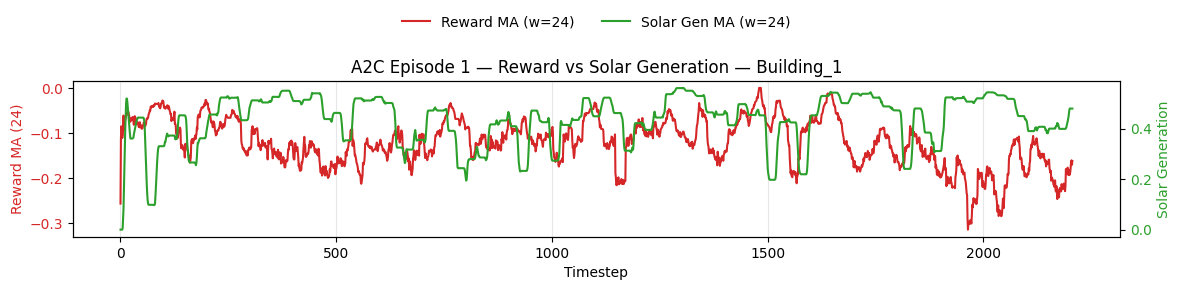

In [17]:
import os, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
from citylearn.citylearn import CityLearnEnv
from matplotlib.ticker import MultipleLocator

def load_a2c_eval_results(path=EVAL_FILE):
    """Load eval results from disk (no in-memory cache)."""
    if not os.path.exists(path):
        raise FileNotFoundError(f"{path} not found. Run evaluate_with_metrics(..., save_path=EVAL_FILE) first.")
    with open(path, "rb") as f:
        data = pickle.load(f)
    print(f"Eval results loaded from {os.path.abspath(path)}.")
    return data

# Load saved A2C eval to plot without re-evaluating
er = load_a2c_eval_results()

# Rebuild vars expected by plots
# actions_stoch: list[(ep_len, n_actions)] -> here n_actions=1 (single building)
if 'actions_disc_list' in er and er['actions_disc_list']:
    actions_stoch = [INT_TO_FRAC[np.asarray(ep, dtype=int)][:, None] for ep in er['actions_disc_list']]
elif 'ep_action_fracs' in er:
    actions_stoch = [np.asarray(ep, dtype=float)[:, None] for ep in er['ep_action_fracs']]
else:
    raise KeyError("No action sequences found in eval results.")

# metrics_stoch: DataFrame with at least 'length'
metrics_stoch = er.get('metrics_df', None)
if metrics_stoch is None or not isinstance(metrics_stoch, pd.DataFrame):
    ep_lengths = np.asarray(er.get('ep_lengths', [len(x) for x in actions_stoch]), dtype=int)
    metrics_stoch = pd.DataFrame({'episode': np.arange(1, len(ep_lengths)+1), 'length': ep_lengths})

building_name = er.get('building_name', 'Building_1')

def unwrap_to_citylearn(env):
    cur, seen = env, set()
    while cur is not None and id(cur) not in seen:
        seen.add(id(cur))
        if isinstance(cur, CityLearnEnv):
            return cur
        cur = getattr(cur, "env", getattr(cur, "unwrapped", None))
    raise RuntimeError("CityLearnEnv not found inside wrappers.")


def capture_ep_series_a2c(building_name="Building_1", deterministic=True, max_steps=None, episode_idx=0, results_path=EVAL_FILE):
    """Build per-step DataFrame from saved eval_results; no env stepping or model usage."""
    er = load_a2c_eval_results(results_path)
    needed = [
        'ep_action_fracs', 'ep_rewards_list', 'ep_net_load',
        'ep_non_shiftable_load', 'ep_price', 'ep_solar_generation'
    ]
    missing = [k for k in needed if k not in er]
    if missing:
        raise ValueError(f"eval_results missing keys: {missing}. Re-run evaluate_with_metrics to regenerate.")
    n_eps = len(er['ep_rewards_list'])
    if not (0 <= episode_idx < n_eps):
        raise IndexError(f"episode_idx {episode_idx} out of range 0..{n_eps-1}")
    if 'actions_disc_list' in er and er['actions_disc_list'] and len(er['actions_disc_list']) > episode_idx:
        a_id = np.asarray(er['actions_disc_list'][episode_idx], dtype=int)
    else:
        frac = np.asarray(er['ep_action_fracs'][episode_idx], dtype=float)
        a_id = np.argmin(np.abs(frac[:, None] - INT_TO_FRAC[None, :]), axis=1)
    a_frac = np.asarray(er['ep_action_fracs'][episode_idx], dtype=float)
    rew    = np.asarray(er['ep_rewards_list'][episode_idx], dtype=float)
    net    = np.asarray(er['ep_net_load'][episode_idx], dtype=float)
    nsl    = np.asarray(er['ep_non_shiftable_load'][episode_idx], dtype=float)
    price  = np.asarray(er['ep_price'][episode_idx], dtype=float)
    solar  = np.asarray(er['ep_solar_generation'][episode_idx], dtype=float)
    L = len(rew)
    if max_steps is not None:
        L = min(L, int(max_steps))
        a_id, a_frac, rew, net, nsl, price, solar = (
            a_id[:L], a_frac[:L], rew[:L], net[:L], nsl[:L], price[:L], solar[:L]
        )
    df = pd.DataFrame({
        't': np.arange(L, dtype=int),
        'action_id': a_id,
        'action_frac': a_frac,
        'reward': rew,
        'net_load': net,
        'non_shiftable_load': nsl,
        'price': price,
        'solar_generation': solar,
    })
    return df, er.get('building_name', building_name)

def add_top_legend(ax_left, ax_right=None, ncol=3, y=1.50, top=0.84, loc='upper center', frameon=False):
    """Place a combined legend above the plot using lines from one or two axes."""
    handles = []
    for ax in (ax_left, ax_right):
        if ax is None:
            continue
        handles.extend(ax.get_lines())
    labels = [h.get_label() for h in handles]
    legend = ax_left.legend(handles, labels, loc=loc, bbox_to_anchor=(0.5, y), ncol=ncol, frameon=frameon)
    if top is not None:
        plt.subplots_adjust(top=top)
    return legend

building_name = 'Building_1'
bld_names = [b.name for b in eval_env.unwrapped.buildings]
if building_name not in bld_names:
    building_name = bld_names[0]
b_idx = bld_names.index(building_name)

# Flatten evaluated actions across episodes -> shape (total_steps, n_actions)
# actions_stoch is collected by evaluate_with_metrics (fractions in [-1,1])
actions_arr = np.concatenate(actions_stoch, axis=0)  # each item shape (ep_len, n_actions)
n_actions = actions_arr.shape[1]
total_steps = actions_arr.shape[0]

# Build episode boundaries from metrics
ep_lengths = metrics_stoch['length'].to_numpy()
ep_offsets = np.cumsum(np.concatenate([[0], ep_lengths[:-1]]))
hour_index = np.arange(total_steps)

# Load pricing
price_file = schema['buildings'][building_name]['pricing']
price_path = os.path.join(ROOT_DIR, price_file)
prc = pd.read_csv(price_path)
T = len(prc)  # 2208

# Helper: map continuous action to 5 labels by nearest of [-1,-0.5,0,0.5,1]
def frac_to_label_idx(vals: np.ndarray) -> np.ndarray:
    return np.argmin(np.abs(vals[..., None] - INT_TO_FRAC[None, :]), axis=-1)


# ----- Plot 1: Actions over Time (for selected building) -----
window = 500
act_series = actions_arr[:, b_idx]
act_ma = pd.Series(act_series).rolling(window, min_periods=1).mean().to_numpy()

plt.figure(figsize=(7,3))
plt.scatter(hour_index, act_series, s=5, alpha=0.35, label='raw')
plt.plot(hour_index, act_ma, color='C2', lw=2, label=f'{window}-step MA')
plt.title(f'A2C Eval Actions over time (Raw + MA) - {building_name}')
plt.xlabel('Step'); plt.ylabel('Action'); plt.grid(True); plt.legend(loc='upper right')
plt.yticks(ticks=INT_TO_FRAC.tolist(), labels=ACTION_LABELS)
plt.tight_layout(); plt.show()


# ----- Plot 2: Action Distribution (quantized to 5 bins like RBC) -----
plt.figure(figsize=(4,3))
labels_idx = frac_to_label_idx(act_series)
counts = pd.Series(labels_idx).value_counts().reindex(range(5)).fillna(0).astype(int)
ax = counts.plot(kind='bar', color=['C0','C1','C2','C3','C4'])
ax.set_xticklabels(ACTION_LABELS, rotation=45, ha='right')
total = counts.sum()
ax.bar_label(ax.containers[0], labels=[f'{int(v)}\n({v/total:.1%})' for v in counts.values])
ax.set_ylim(0, counts.max()*1.5)
plt.ylabel('Count'); plt.title('Action Distribution'); plt.tight_layout(); plt.show()


def plot_first_30_steps_actions_vs_loads_a2c(building_name="Building_1", deterministic=True):
    """Plot first 30 steps: net load vs non-shiftable load with action (discrete bins in [-1..1])."""
    df30, bname = capture_ep_series_a2c(building_name, deterministic=deterministic, max_steps=30)

    t = df30['t'].to_numpy()
    net = df30['net_load'].to_numpy()
    nsl = df30['non_shiftable_load'].to_numpy()
    act = df30['action_frac'].to_numpy()

    fig, ax1 = plt.subplots(figsize=(10.5, 3.6))
    ax1.plot(t, net, color='C4', marker='o', label='Net Load (with storage)')
    ax1.plot(t, nsl, color='C1', ls='--', marker='x', label='Non-shiftable Load (baseline)')
    ax1.set_xlabel('Timestep')
    ax1.set_xticks(t[::2])
    ax1.set_ylabel('Load')
    ax1.set_ylim(-2, 4)  # enforce requested load range
    ax1.yaxis.set_major_locator(MultipleLocator(2))  # enforce ticks every 2 units
    ax1.grid(True, alpha=0.3)

    ax2 = ax1.twinx()
    ax2.step(t, act, where='mid', color='C0', label='Action')
    ax2.set_ylabel('Action')
    ax2.set_ylim(-1.1, 1.1)
    ax2.set_yticks(INT_TO_FRAC.tolist())
    try:
        ax2.set_yticklabels(ACTION_LABELS)
    except Exception:
        ax2.set_yticklabels(['discharge_full','discharge_half','idle','charge_half','charge_full'])
    add_top_legend(ax1, ax2)
    plt.title(f'A2C — first 30 steps — {bname} (deterministic={deterministic})')
    plt.tight_layout()
    plt.show()

def plot_ep1_reward_vs_obs_a2c(building_name="Building_1", deterministic=True):
    """Three plots: Reward vs Price, Solar, Net for episode 1."""
    df, bname = capture_ep_series_a2c(building_name, deterministic=deterministic, max_steps=None)

    window_reward = 24
    window_x = 24
    t = df['t'].to_numpy()
    reward_ma = pd.Series(df['reward']).rolling(window_reward, min_periods=1).mean().to_numpy()
    price_ma  = pd.Series(df['price']).rolling(window_x, min_periods=1).mean().to_numpy()
    solar_ma  = pd.Series(df['solar_generation']).rolling(window_x, min_periods=1).mean().to_numpy()
    net_ma    = pd.Series(df['net_load']).rolling(window_x, min_periods=1).mean().to_numpy()

    # 4) Reward vs Net Load
    fig, ax1 = plt.subplots(figsize=(12, 3.5))
    ax1.plot(t, reward_ma, color='C3', label=f'Reward MA (w={window_reward})')
    ax1.set_xlabel('Timestep'); ax1.set_ylabel(f'Reward MA ({window_reward})', color='C3')
    ax1.tick_params(axis='y', labelcolor='C3'); ax1.grid(True, axis='x', alpha=0.3)
    ax2 = ax1.twinx()
    ax2.plot(t, net_ma, color='C4', label=f'Net Load MA (w={window_x})')
    ax2.set_ylabel('Net Electricity Consumption', color='C4'); ax2.tick_params(axis='y', labelcolor='C4')
    add_top_legend(ax1, ax2)
    ax1.set_title(f'A2C Episode 1 — Reward vs Net Load — {bname}')
    plt.tight_layout(); plt.show()

    # 5) Reward vs Electricity Price
    fig, ax1 = plt.subplots(figsize=(12, 3.5))
    ax1.plot(t, reward_ma, color='C3', label=f'Reward MA (w={window_reward})')
    ax1.set_xlabel('Timestep'); ax1.set_ylabel(f'Reward MA ({window_reward})', color='C3')
    ax1.tick_params(axis='y', labelcolor='C3'); ax1.grid(True, axis='x', alpha=0.3)
    ax2 = ax1.twinx()
    ax2.plot(t, price_ma, color='C0', label=f'Price MA (w={window_x})')
    ax2.set_ylabel('Electricity Price', color='C0'); ax2.tick_params(axis='y', labelcolor='C0')
    add_top_legend(ax1, ax2)
    ax1.set_title(f'A2C Episode 1 — Reward vs Electricity Price — {bname}')
    plt.tight_layout(); plt.show()

    # 6) Reward vs Solar Generation
    fig, ax1 = plt.subplots(figsize=(12, 3.5))
    ax1.plot(t, reward_ma, color='C3', label=f'Reward MA (w={window_reward})')
    ax1.set_xlabel('Timestep'); ax1.set_ylabel(f'Reward MA ({window_reward})', color='C3')
    ax1.tick_params(axis='y', labelcolor='C3'); ax1.grid(True, axis='x', alpha=0.3)
    ax2 = ax1.twinx()
    ax2.plot(t, solar_ma, color='C2', label=f'Solar Gen MA (w={window_x})')
    ax2.set_ylabel('Solar Generation', color='C2'); ax2.tick_params(axis='y', labelcolor='C2')
    add_top_legend(ax1, ax2)
    ax1.set_title(f'A2C Episode 1 — Reward vs Solar Generation — {bname}')
    plt.tight_layout(); plt.show()


# ----- Plot 3: Actions vs Loads (first 30 steps) -----
plot_first_30_steps_actions_vs_loads_a2c(building_name="Building_1", deterministic=False)


# ----- Plot 4,5,6: Actions vs Observations(Net Load, Price, Solar Generation) - first episode -----
plot_ep1_reward_vs_obs_a2c(building_name="Building_1", deterministic=False)

#### Cumulative Reward

Episodes available (per env):
    env_id  episode  steps
0        0        0   2207
1        0        1   2207
2        0        2   2207
3        0        3   2207
4        0        4   2207
5        0        5   2207
6        0        6   2207
7        0        7   2207
8        0        8   2207
9        0        9   2207
10       0       10   2207
11       0       11   2207
12       0       12   2207
13       0       13   2207
14       0       14   2207
15       0       15   2207
16       0       16   2207
17       0       17   2207
18       0       18   2207
19       0       19   2207
Plotting env_id=0, episode=0


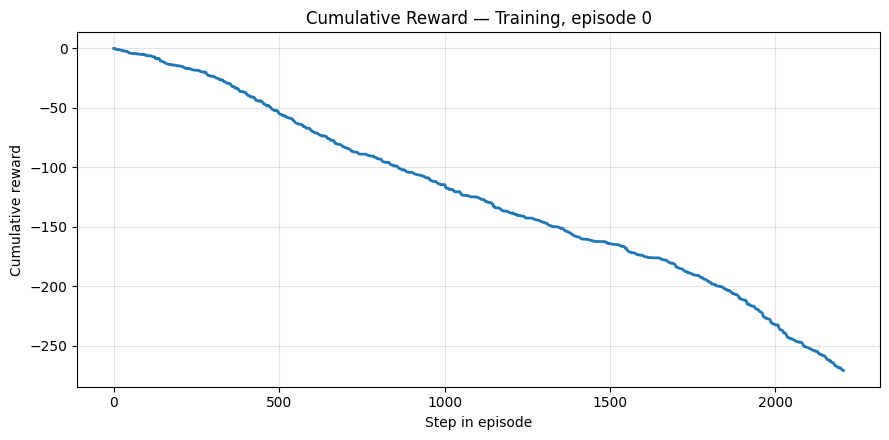

Episode length: 2207 steps | Return: -270.704


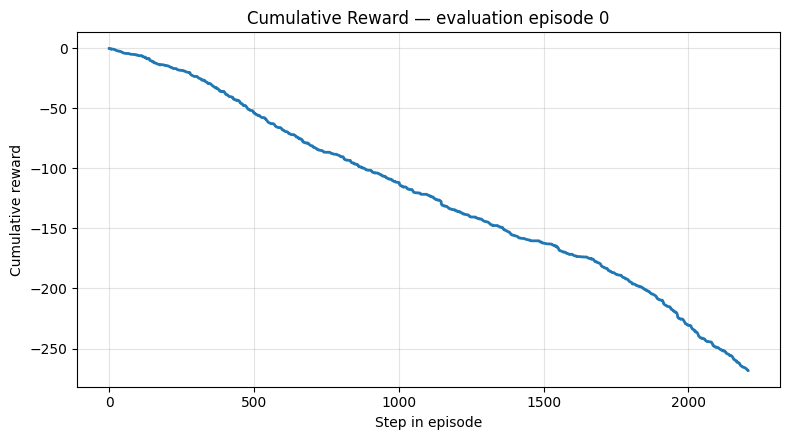

Episode 0 length: 2207 steps | Return: -268.277


In [18]:
# ----- Plot cumulative reward for ONE episode from TRAIN_STEPS_FILE -----
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ENV_ID = 0            
EPISODE_IDX = 0      # -1 = last episode of ENV_ID

csv_path = TRAIN_STEPS_FILE  
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"TRAIN_STEPS_FILE not found: {csv_path}")

df = pd.read_csv(csv_path)

for col in ("reward", "env_id", "episode", "global_step"):
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")
need_cols = [c for c in ("env_id", "episode", "reward") if c in df.columns]
df = df.dropna(subset=need_cols)

episodes_per_env = (
    df.groupby(["env_id", "episode"], as_index=False)["reward"]
      .size()
      .rename(columns={"size": "steps"})
      .sort_values(["env_id", "episode"])
)
print("Episodes available (per env):")
print(episodes_per_env.head(20))

env_mask = (df["env_id"] == ENV_ID) if "env_id" in df.columns else np.ones(len(df), dtype=bool)
df_env = df.loc[env_mask].copy()
if "episode" not in df_env.columns:
    raise KeyError("CSV has no 'episode' column; cannot segment by episode.")

episodes = sorted(df_env["episode"].dropna().astype(int).unique())
if not episodes:
    raise ValueError(f"No episodes found for env_id={ENV_ID} in {csv_path}")

ep_chosen = episodes[EPISODE_IDX] if EPISODE_IDX != -1 else episodes[-1]
print(f"Plotting env_id={ENV_ID}, episode={ep_chosen}")

order_cols = ["global_step"] if "global_step" in df_env.columns else None
df_ep = df_env.loc[df_env["episode"] == ep_chosen].copy()
if order_cols:
    df_ep = df_ep.sort_values(order_cols)

# cumulative reward
df_ep["reward"] = pd.to_numeric(df_ep["reward"], errors="coerce").fillna(0.0)
df_ep["cum_reward"] = df_ep["reward"].cumsum()
df_ep["t_in_ep"] = np.arange(len(df_ep), dtype=int)


plt.figure(figsize=(9, 4.5))
plt.plot(df_ep["t_in_ep"], df_ep["cum_reward"], lw=2)
plt.title(f"Cumulative Reward — Training, episode {ep_chosen}")
plt.xlabel("Step in episode")
plt.ylabel("Cumulative reward")
plt.grid(True, alpha=0.35)
plt.tight_layout()
plt.show()

print(f"Episode length: {len(df_ep)} steps | Return: {df_ep['cum_reward'].iloc[-1]:.3f}")


# ----- Cumulative reward over timesteps for the first evaluation episode -----
import os, pickle
import numpy as np
import matplotlib.pyplot as plt

assert 'EVAL_FILE' in globals(), "EVAL_FILE is not defined."
if not os.path.exists(EVAL_FILE):
    raise FileNotFoundError(f"Eval file not found: {os.path.abspath(EVAL_FILE)}")

with open(EVAL_FILE, "rb") as f:
    er = pickle.load(f)

def _as_1d_float(x):
    return np.asarray(x, dtype=float).ravel()

def first_episode_step_rewards(data):
    """
    Try common layouts produced by your notebooks:
      - 'ep_rewards_list': list of per-episode step-reward arrays/lists
      - ('step_rewards' + 'ep_lengths'): flat step rewards + per-episode lengths
    Returns: np.ndarray of step rewards for episode 0.
    """
    if isinstance(data, dict):
        # Preferred: list of step-reward sequences per episode
        if "ep_rewards_list" in data and len(data["ep_rewards_list"]) > 0:
            ep0 = data["ep_rewards_list"][0]
            # Some pipelines store floats (already per-episode sum) -> then we can't do cumulative steps
            if isinstance(ep0, (list, tuple, np.ndarray)):
                return _as_1d_float(ep0)

        # Fallback: flat step_rewards segmented by ep_lengths
        if "step_rewards" in data and "ep_lengths" in data:
            step_rewards = _as_1d_float(data["step_rewards"])
            ep_lengths   = np.asarray(data["ep_lengths"], dtype=int).ravel()
            if ep_lengths.size == 0:
                raise ValueError("ep_lengths is empty in eval file.")
            L0 = int(ep_lengths[0])
            if L0 <= 0:
                raise ValueError(f"First episode length is non-positive: {L0}")
            if step_rewards.size < L0:
                raise ValueError(f"Not enough step rewards for first episode: have {step_rewards.size}, need {L0}")
            return step_rewards[:L0]

        for k in ("episode_step_rewards", "rewards_per_step", "ep0_step_rewards"):
            if k in data:
                return _as_1d_float(data[k])

    raise ValueError(
        "Could not find per-step rewards for episode 0 in EVAL_FILE. "
        "Expected 'ep_rewards_list' (list of per-step arrays) or ('step_rewards' + 'ep_lengths'). "
        f"Available keys: {list(data.keys()) if isinstance(data, dict) else type(data)}"
    )

# Extract per-step rewards for first eval episode
r0 = first_episode_step_rewards(er)
cum0 = np.cumsum(r0)

# Plot
plt.figure(figsize=(8, 4.5))
plt.plot(np.arange(len(cum0)), cum0, lw=2)
plt.title("Cumulative Reward — evaluation episode 0")
plt.xlabel("Step in episode")
plt.ylabel("Cumulative reward")
plt.grid(True, alpha=0.35)
plt.tight_layout()
plt.show()

print(f"Episode 0 length: {len(r0)} steps | Return: {cum0[-1]:.3f}")

#### DecisionTree

Loaded 110400 rows from /hkfs/home/haicore/iai/cj9272/logs/a2c/a2c_train_steps_50episodes_best_params.csv
n_features: 11 sample: ['battery_energy_balance', 'battery_soc', 'chargers_load', 'cooling_load', 'dhw_load', 'heating_load', 'net_load', 'non_shiftable_load', 'price', 'solar']
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best balanced_accuracy: 0.7950800105049315
Best params: {'ccp_alpha': 0.0005, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Surrogate Tree Accuracy: 0.793
Confusion matrix (rows=true, cols=pred):
 [[4301   50  971    0    0]
 [1747 2868  895    0    0]
 [   0   66 6029    0    0]
 [   0   58   26 3960 1818]
 [   0   44   26    6 4735]]
                precision    recall  f1-score   support

discharge_full       0.71      0.81      0.76      5322
discharge_half       0.93      0.52      0.67      5510
          idle       0.76      0.99      0.86      6095
 

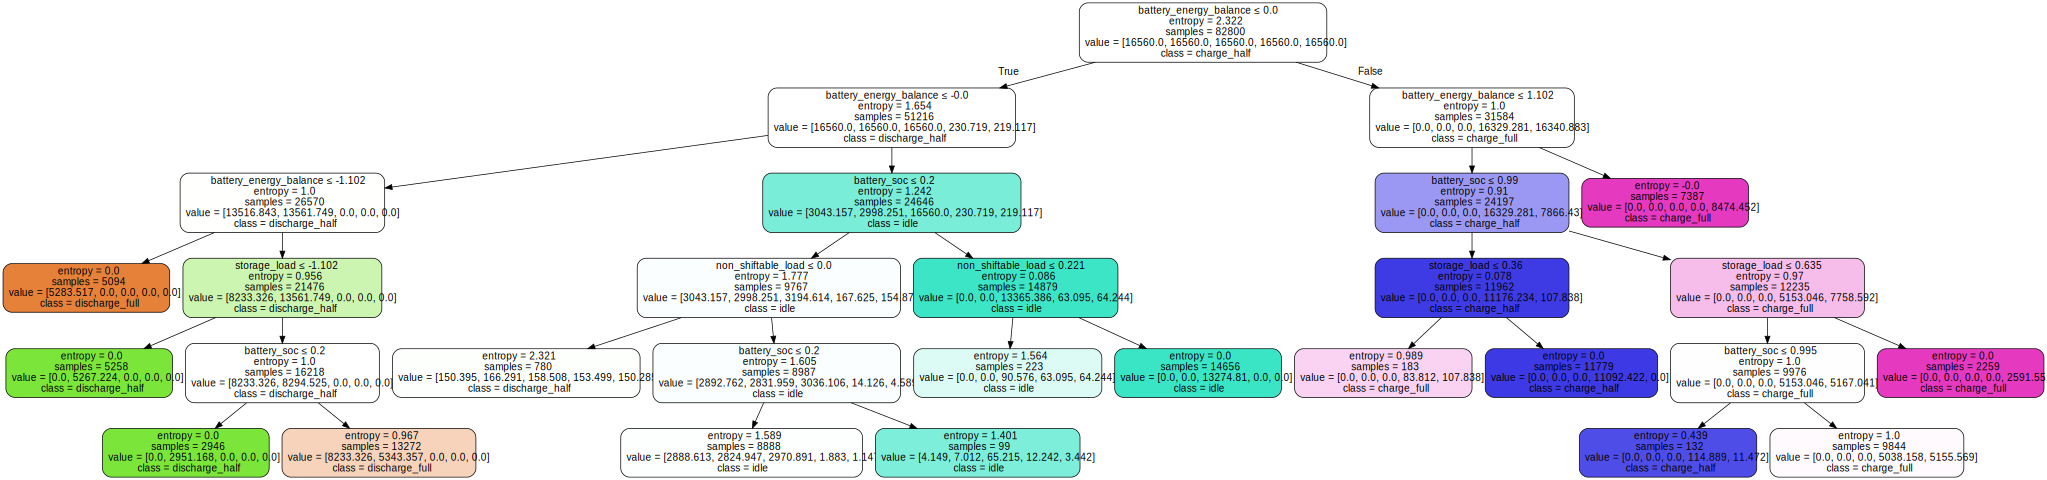

In [12]:
# ---- Explainability (A2C): Decision Tree (state -> action) ----
# Lernt einen kleinen Surrogate-Tree auf (Observation -> gewählte diskrete Aktion)
# und visualisiert ihn. Funktioniert mit deinen A2C-Train-Logs.

import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ---------- 1) Datensatz laden ----------
def _load_policy_dataset():
    csv_path = TRAIN_STEPS_FILE
    if csv_path and os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        print(f"Loaded {len(df)} rows from {os.path.abspath(csv_path)}")
        return df
    # Fallback: In-Memory Callback
    if 'train_callback' in globals() and hasattr(train_callback, 'df') and train_callback.df is not None and len(train_callback.df):
        print("Using in-memory train_callback.df")
        return train_callback.df.copy()
    raise FileNotFoundError("No training dataset found. Set TRAIN_STEPS_FILE or ensure a2c_train_steps_*.csv exists.")

df_steps = _load_policy_dataset()

# ---------- 2) Features & Label vorbereiten ----------
target_col = "action_id"  # A2C loggt diskrete ID (0..4)
if target_col not in df_steps.columns:
    # manche Logs nennen die Spalte nur 'action'
    if 'action' in df_steps.columns:
        df_steps[target_col] = df_steps['action'].astype(int)
    else:
        raise KeyError(f"Target column '{target_col}' not found in df.")

# Spalten, die wir sicher NICHT als Features nutzen wollen (Leaks/Meta)
explicit_drop = {
    "global_step", "env_id", "episode",
    "action_id", "action", "action_label", "action_frac",
    "reward", "done"
}
# zusätzlich alles droppen, was erkennbar mit Aktion/Reward zu tun hat
leak_prefixes = ("action", "reward", "done", "adv", "return", "value")

num_bool_cols = df_steps.select_dtypes(include=[np.number, bool]).columns
feat_cols = []
for c in num_bool_cols:
    if c in explicit_drop: 
        continue
    if c == target_col:
        continue
    if any(c.startswith(p) for p in leak_prefixes):
        continue
    feat_cols.append(c)

feat_cols = sorted(feat_cols, key=lambda x: x)
assert len(feat_cols) > 0, f"No features selected – check your dataframe columns! (numeric cols: {list(num_bool_cols)[:10]})"
print("n_features:", len(feat_cols), "sample:", feat_cols[:10])

feature_names = list(feat_cols)
X = df_steps[feat_cols].to_numpy()
y = df_steps[target_col].astype(int).to_numpy()

# Train/Test-Split mit Stratify, damit Klassenverteilung erhalten bleibt
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0, stratify=y
)

# ---------- 3) Decision Tree trainieren (GridSearch) ----------
param_grid = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [5],
    "min_samples_leaf": [1, 5, 10],
    "min_samples_split": [2, 5, 10],
    "class_weight": ["balanced"],
    "ccp_alpha": [0.0, 0.0005, 0.001, 0.005],
    "splitter": ["best"]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
grid = GridSearchCV(
    DecisionTreeClassifier(random_state=0),
    param_grid=param_grid,
    scoring="balanced_accuracy",
    cv=cv,
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)
print("Best balanced_accuracy:", grid.best_score_)
print("Best params:", grid.best_params_)

clf = grid.best_estimator_

# ---------- 4) Qualität ausgeben ----------
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Surrogate Tree Accuracy: {acc:.3f}")
print("Confusion matrix (rows=true, cols=pred):\n", confusion_matrix(y_test, y_pred))

# Klassennamen: ACTION_LABELS falls vorhanden, sonst aus INT_TO_FRAC ableiten
if 'ACTION_LABELS' in globals() and isinstance(ACTION_LABELS, (list, tuple)) and len(ACTION_LABELS) >= (int(np.max(y))+1):
    class_names = ACTION_LABELS
else:
    if 'INT_TO_FRAC' in globals():
        # mappe [-1,-0.5,0,0.5,1] auf Labels
        frac = [str(v) for v in list(INT_TO_FRAC)]
        # hübschere Defaults:
        mapping = { -1.0:"discharge_full", -0.5:"discharge_half", 0.0:"idle", 0.5:"charge_half", 1.0:"charge_full" }
        class_names = [mapping.get(float(INT_TO_FRAC[i]), frac[i]) for i in range(int(np.max(y))+1)]
    else:
        class_names = [str(i) for i in range(int(np.max(y))+1)]

print(classification_report(y_test, y_pred, target_names=class_names))

# ---------- 5) Globale Erklärungen ----------
print("\nTop feature importances:")
imp = clf.feature_importances_
assert len(imp) == len(feature_names), "Mismatch zwischen Importances und Feature-Namen."
imp_idx = np.argsort(imp)[::-1]
for i in imp_idx[:10]:
    if imp[i] <= 0: break
    print(f"- {feature_names[i]}: {imp[i]:.4f}")

# ---------- 6) Lokale Erklärung ----------
def explain_sample(idx_in_df: int):
    """Print the decision path für eine gegebene Zeile aus df_steps."""
    x = df_steps.iloc[idx_in_df][feat_cols].to_numpy().reshape(1, -1)
    true_a = int(df_steps.iloc[idx_in_df][target_col])
    pred_a = int(clf.predict(x)[0])
    proba  = clf.predict_proba(x)[0]
    tree = clf.tree_
    node = 0
    path = []
    while tree.feature[node] != -2:  # -2 => leaf
        f_idx = tree.feature[node]
        thr = tree.threshold[node]
        val = float(x[0, f_idx])
        go_left = val <= thr
        path.append((feature_names[f_idx], val, thr, "left" if go_left else "right"))
        node = tree.children_left[node] if go_left else tree.children_right[node]
    def _label(a):
        try:
            return class_names[a]
        except Exception:
            return str(a)
    print(f"True action: {true_a} ({_label(true_a)}), Pred: {pred_a} ({_label(pred_a)})")
    print("Proba:", {class_names[i]: float(f"{p:.3f}") for i,p in enumerate(proba)})
    print("Decision path:")
    for name, val, thr, side in path:
        print(f" - {name}: {val:.4f} <= {thr:.4f} -> {side}")
    return pred_a

# Beispiel: zufälliger Datensatzindex
_ = explain_sample(idx_in_df=np.random.randint(0, len(df_steps)))

# ---------- 7) Visualisierung ----------
try:
    from sklearn.tree import export_graphviz
    import graphviz
    from IPython.display import SVG, display

    dot = export_graphviz(
        clf,
        out_file=None,
        feature_names=feature_names,
        class_names=class_names,
        filled=True,
        rounded=True,
        special_characters=True,
    )
    src = graphviz.Source(dot)
    display(SVG(src.pipe(format='svg')))  # crisp, scalable
except Exception as e:
    print("Graphviz unavailable; fallback to matplotlib. Error:", e)
    plt.figure(figsize=(32, 16), dpi=250)
    plot_tree(
        clf,
        feature_names=feature_names,
        class_names=class_names,
        filled=True,
        rounded=True,
        max_depth=4,
        fontsize=14
    )
    plt.tight_layout()
    plt.show()